# Leveraging Student Information to Enhance College Persistence

## Part 3: Model Development and Validation Results Using Ensemble Algorithms
- Random Forests
- Gradient Boosting

### Step 1: Read the Data

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_auc_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Read dataset
df = pd.read_csv('data/DataForHSStudentsFor2YearCollege.csv')
df.head()
df.shape

,HSRating,ESL,HSProgram,SummerBeforeHS,SuccessScholarship,DualEnrollment,Gender,Race,HSRegion,TimeUntilFCE,CollegeRegion,MovedAfterHS,persistIndicator
0,3,0,0,1,2,0,0,4,3,2.580645,3,0,1
1,6,1,0,0,1,0,0,4,3,2.483871,7,1,0
2,6,1,0,0,2,0,1,4,3,2.516129,7,1,1
3,6,0,0,1,2,0,1,6,3,2.580645,7,1,0
4,6,1,0,1,2,0,0,4,3,2.580645,7,1,0


(1393, 13)

In [3]:
#Shuffle the dataset
df = shuffle(df, random_state= 42).reset_index(drop = True)
df.head()

,HSRating,ESL,HSProgram,SummerBeforeHS,SuccessScholarship,DualEnrollment,Gender,Race,HSRegion,TimeUntilFCE,CollegeRegion,MovedAfterHS,persistIndicator
0,0,0,0,0,1,0,1,1,4,2.709677,9,0,0
1,6,0,0,0,3,0,1,3,6,0.322581,8,0,1
2,5,0,0,1,1,0,0,4,3,2.806452,11,1,1
3,5,0,0,1,2,0,1,4,3,0.451613,3,0,1
4,1,0,0,0,1,0,1,6,4,2.709677,9,0,0


### Step 2: Develop models using ensemble algorithms

In [4]:
#Create train/test datasets. Use the default test_size of 25%.
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['persistIndicator']),df['persistIndicator'],random_state = 42, stratify = df['persistIndicator'])

In [5]:
#Scale all the variables
transformer = make_column_transformer((StandardScaler(), list(X_train.columns)),
                                      remainder = 'passthrough' )

### A. Build a random forest model

In [6]:
#Build a pipeline for a random forest model
randomForestPipe = Pipeline([('transformer',transformer),
                     ('randomForest',RandomForestClassifier(oob_score=True, random_state = 42))])

In [7]:
#Tune the random forest - define parameters for the search algorithm
n_estimators = np.linspace(100, 1000, int((1000-100)/200) + 1, dtype=int) # number of trees
max_features = ['auto','log2', None] # number of features to consider at every split
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200] # maximum number of levels in tree
min_samples_leaf = [10, 20, 50] # minimum number of samples required at each leaf
bootstrap = [True, False] # method of selecting samples for training each tree
criterion = ['gini', 'entropy', 'log_loss']

random_grid = {'randomForest__n_estimators':n_estimators,
               'randomForest__max_features':max_features,
               'randomForest__max_depth':max_depth,
               'randomForest__min_samples_leaf':min_samples_leaf,
               'randomForest__bootstrap':bootstrap,
               'randomForest__criterion':criterion}

random_grid

{'randomForest__n_estimators': array([ 100,  325,  550,  775, 1000]),
 'randomForest__max_features': ['auto', 'log2', None],
 'randomForest__max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
 'randomForest__min_samples_leaf': [10, 20, 50],
 'randomForest__bootstrap': [True, False],
 'randomForest__criterion': ['gini', 'entropy', 'log_loss']}

In [8]:
#Grid search for the random forest
roc_grid_randomForest = RandomizedSearchCV(randomForestPipe,
                        param_distributions = random_grid, 
                        random_state = 42, n_jobs = 4).fit(X_train, y_train)
roc_grid_randomForest.best_params_

{'randomForest__n_estimators': 100,
 'randomForest__min_samples_leaf': 20,
 'randomForest__max_features': 'auto',
 'randomForest__max_depth': 5,
 'randomForest__criterion': 'log_loss',
 'randomForest__bootstrap': True}

In [9]:
#Build a random forest with the best parameters
randomForestBestPipe = Pipeline([('transformer',transformer),
                     ('randomForest',RandomForestClassifier(
                     n_estimators = roc_grid_randomForest.best_params_.get('randomForest__n_estimators'), 
                     min_samples_leaf = roc_grid_randomForest.best_params_.get('randomForest__min_samples_leaf'),
                     max_features = roc_grid_randomForest.best_params_.get('randomForest__max_features'),
                     max_depth = roc_grid_randomForest.best_params_.get('randomForest__max_depth'),
                     bootstrap = roc_grid_randomForest.best_params_.get('randomForest__bootstrap'),
                     criterion = roc_grid_randomForest.best_params_.get('randomForest__criterion'),
                     random_state = 42))]).fit(X_train,y_train)

In [10]:
#Calculate predicted values, both the classifier and the probability
y_train_predicted = randomForestBestPipe.predict(X_train)
y_test_predicted = randomForestBestPipe.predict(X_test)

y_train_predicted_proba = randomForestBestPipe.predict_proba(X_train)
y_test_predicted_proba = randomForestBestPipe.predict_proba(X_test)

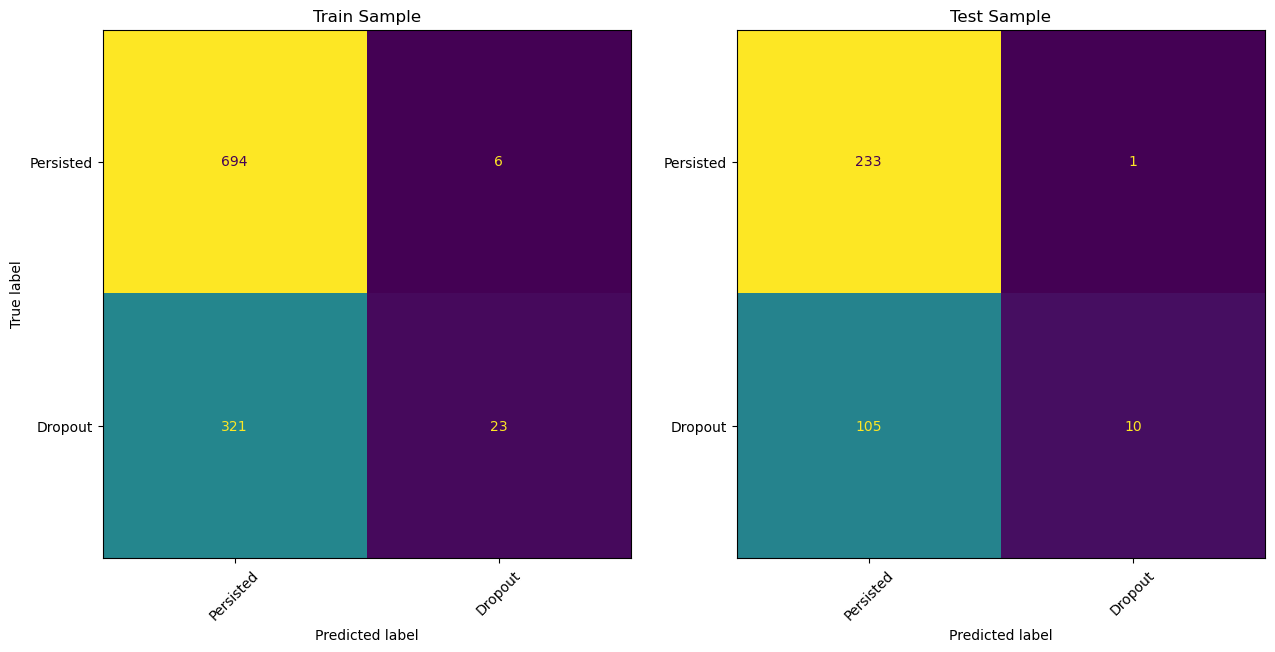

In [11]:
#Display the confusion matrix
dataList = [y_train,y_test]
predictedList = [y_train_predicted, y_test_predicted]
dataLabels = ['Train Sample','Test Sample']

fig, ax = plt.subplots(1,2, figsize = (15,15))
#plt.rcParams.update({'font.size': 20})

for i,j in enumerate(predictedList):
    confusionMatrix= confusion_matrix(dataList[i],j)
    disp = ConfusionMatrixDisplay(confusionMatrix, display_labels = ['Persisted','Dropout'])
    disp.plot(ax=ax[i], xticks_rotation=45)
    disp.ax_.set_title(dataLabels[i])
    disp.im_.colorbar.remove()
    if i!=0:
        disp.ax_.set_ylabel('')

plt.show();

- In the train sample, there are 321 instances of false negatives (classified as persistent even though a dropout), or missed opportunities where the necessary interventions were not taken to retain students in college. The test sample reports 105 false negatives.
- The train sample has only six false positives. This statistic decreases to one in the test sample.
- It is imperative to strive for minimizing both false negatives and false positives in order to maximize success in retaining students and effectively utilizing resources.

In [12]:
#Function to generate summary stats, accuracy, precision, recall, f1-score and AUC
def generateModelSummaryStats(y_train, y_train_predicted, y_test, y_test_predicted,y_train_predicted_proba,y_test_predicted_proba):
    trainStats = []
    testStats = []
    
    trainStats.append(np.round(accuracy_score(y_train,y_train_predicted),3))
    if (np.sum(y_train_predicted) == 0):
        trainStats.append("N/A")
    else:
        trainStats.append(np.round(precision_score(y_train,y_train_predicted),3))
    trainStats.append(np.round(recall_score(y_train,y_train_predicted),3))
    trainStats.append(np.round(f1_score(y_train,y_train_predicted),3))
    trainStats.append(np.round(roc_auc_score(y_train, y_train_predicted_proba[:,1]),3))
    
    testStats.append(np.round(accuracy_score(y_test,y_test_predicted),3))
    if (np.sum(y_test_predicted) == 0):
        testStats.append("N/A")
    else:
        testStats.append(np.round(precision_score(y_test,y_test_predicted),3))
    testStats.append(np.round(recall_score(y_test,y_test_predicted),3))
    testStats.append(np.round(f1_score(y_test,y_test_predicted),3))
    testStats.append(np.round(roc_auc_score(y_test, y_test_predicted_proba[:,1]),3))
    
    #Summarize results
    listOfStats = ['Accuracy','Precision','Recall','F1 Score','AUC']
    dfStats = pd.DataFrame(zip(listOfStats, trainStats, testStats), columns = ['Metric','Train Sample','Test Sample'])
    return(dfStats)

In [13]:
#Generate summary statistics
generateModelSummaryStats(y_train, y_train_predicted, y_test, y_test_predicted,y_train_predicted_proba,y_test_predicted_proba)

,Metric,Train Sample,Test Sample
0,Accuracy,0.687,0.696
1,Precision,0.793,0.909
2,Recall,0.067,0.087
3,F1 Score,0.123,0.159
4,AUC,0.714,0.639


In [14]:
#Generate the data to create the ROC data
y_data = [y_train, y_test]
y_predict_proba = [y_train_predicted_proba[:,1], y_test_predicted_proba[:,1]]

for i in range(0,2):
    fpr, tpr, thresholds = roc_curve(y_data[i], y_predict_proba[i])
    if (i == 0):
        fpr_train = fpr
        tpr_train = tpr
        thresholds_train = thresholds
    else:
        fpr_test = fpr
        tpr_test = tpr
        thresholds_test = thresholds

fpr_tpr_train = pd.DataFrame({'fpr':fpr_train,'tpr':tpr_train})
fpr_tpr_test = pd.DataFrame({'fpr':fpr_test,'tpr':tpr_test})
fpr_tpr_train.to_csv("data/fpr_tpr_RandomForest_Train.csv")
fpr_tpr_test.to_csv("data/fpr_tpr_RandomForest_Test.csv")

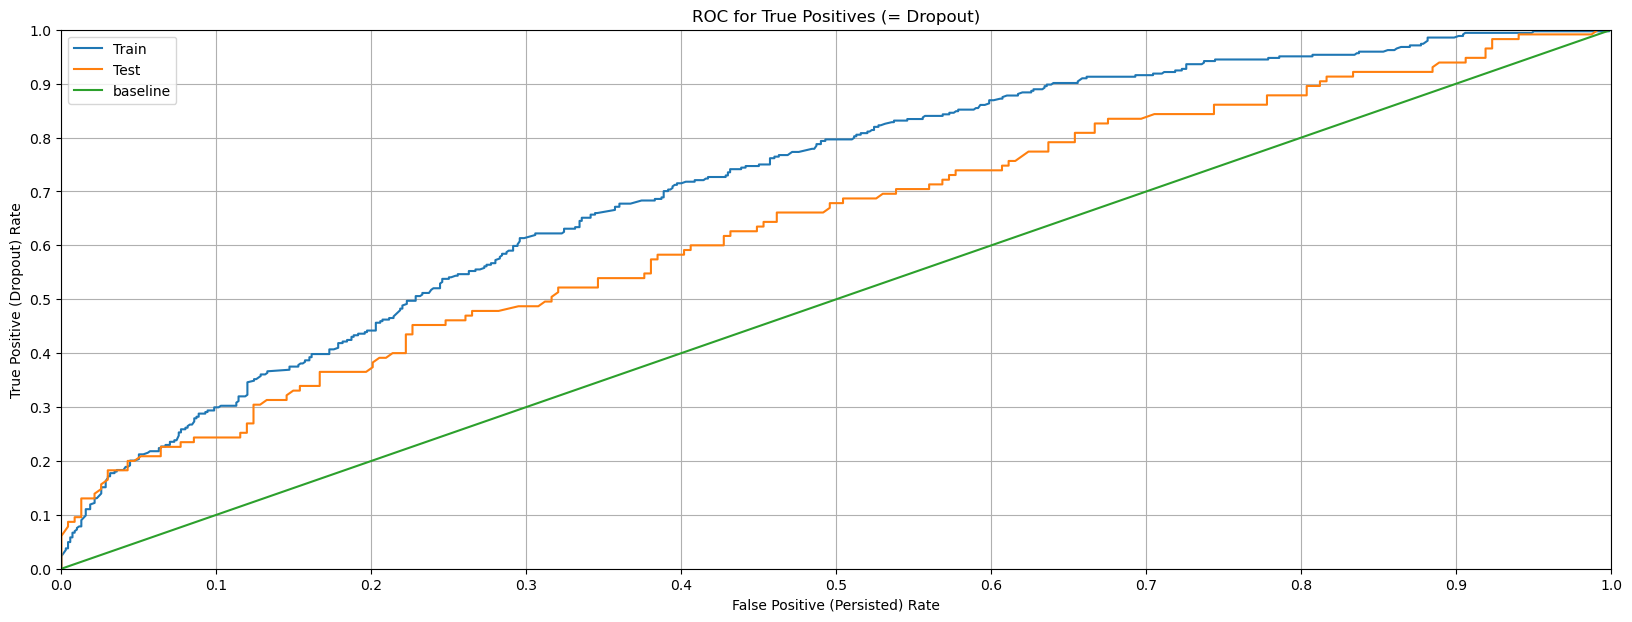

In [15]:
#Generate a chart to observe the rank ordering capability of the model
fig,ax = plt.subplots(figsize = (20, 7))

plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')

plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.xlabel('False Positive (Persisted) Rate')
plt.ylabel('True Positive (Dropout) Rate')
plt.title('ROC for True Positives (= Dropout)')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.legend();

- Our model's ability to identify students who dropped out can be analyzed through the above curve.
- Specifically, on the test sample, it predicts 39% of the students who dropped out within the bottom 20% of students who persisted.

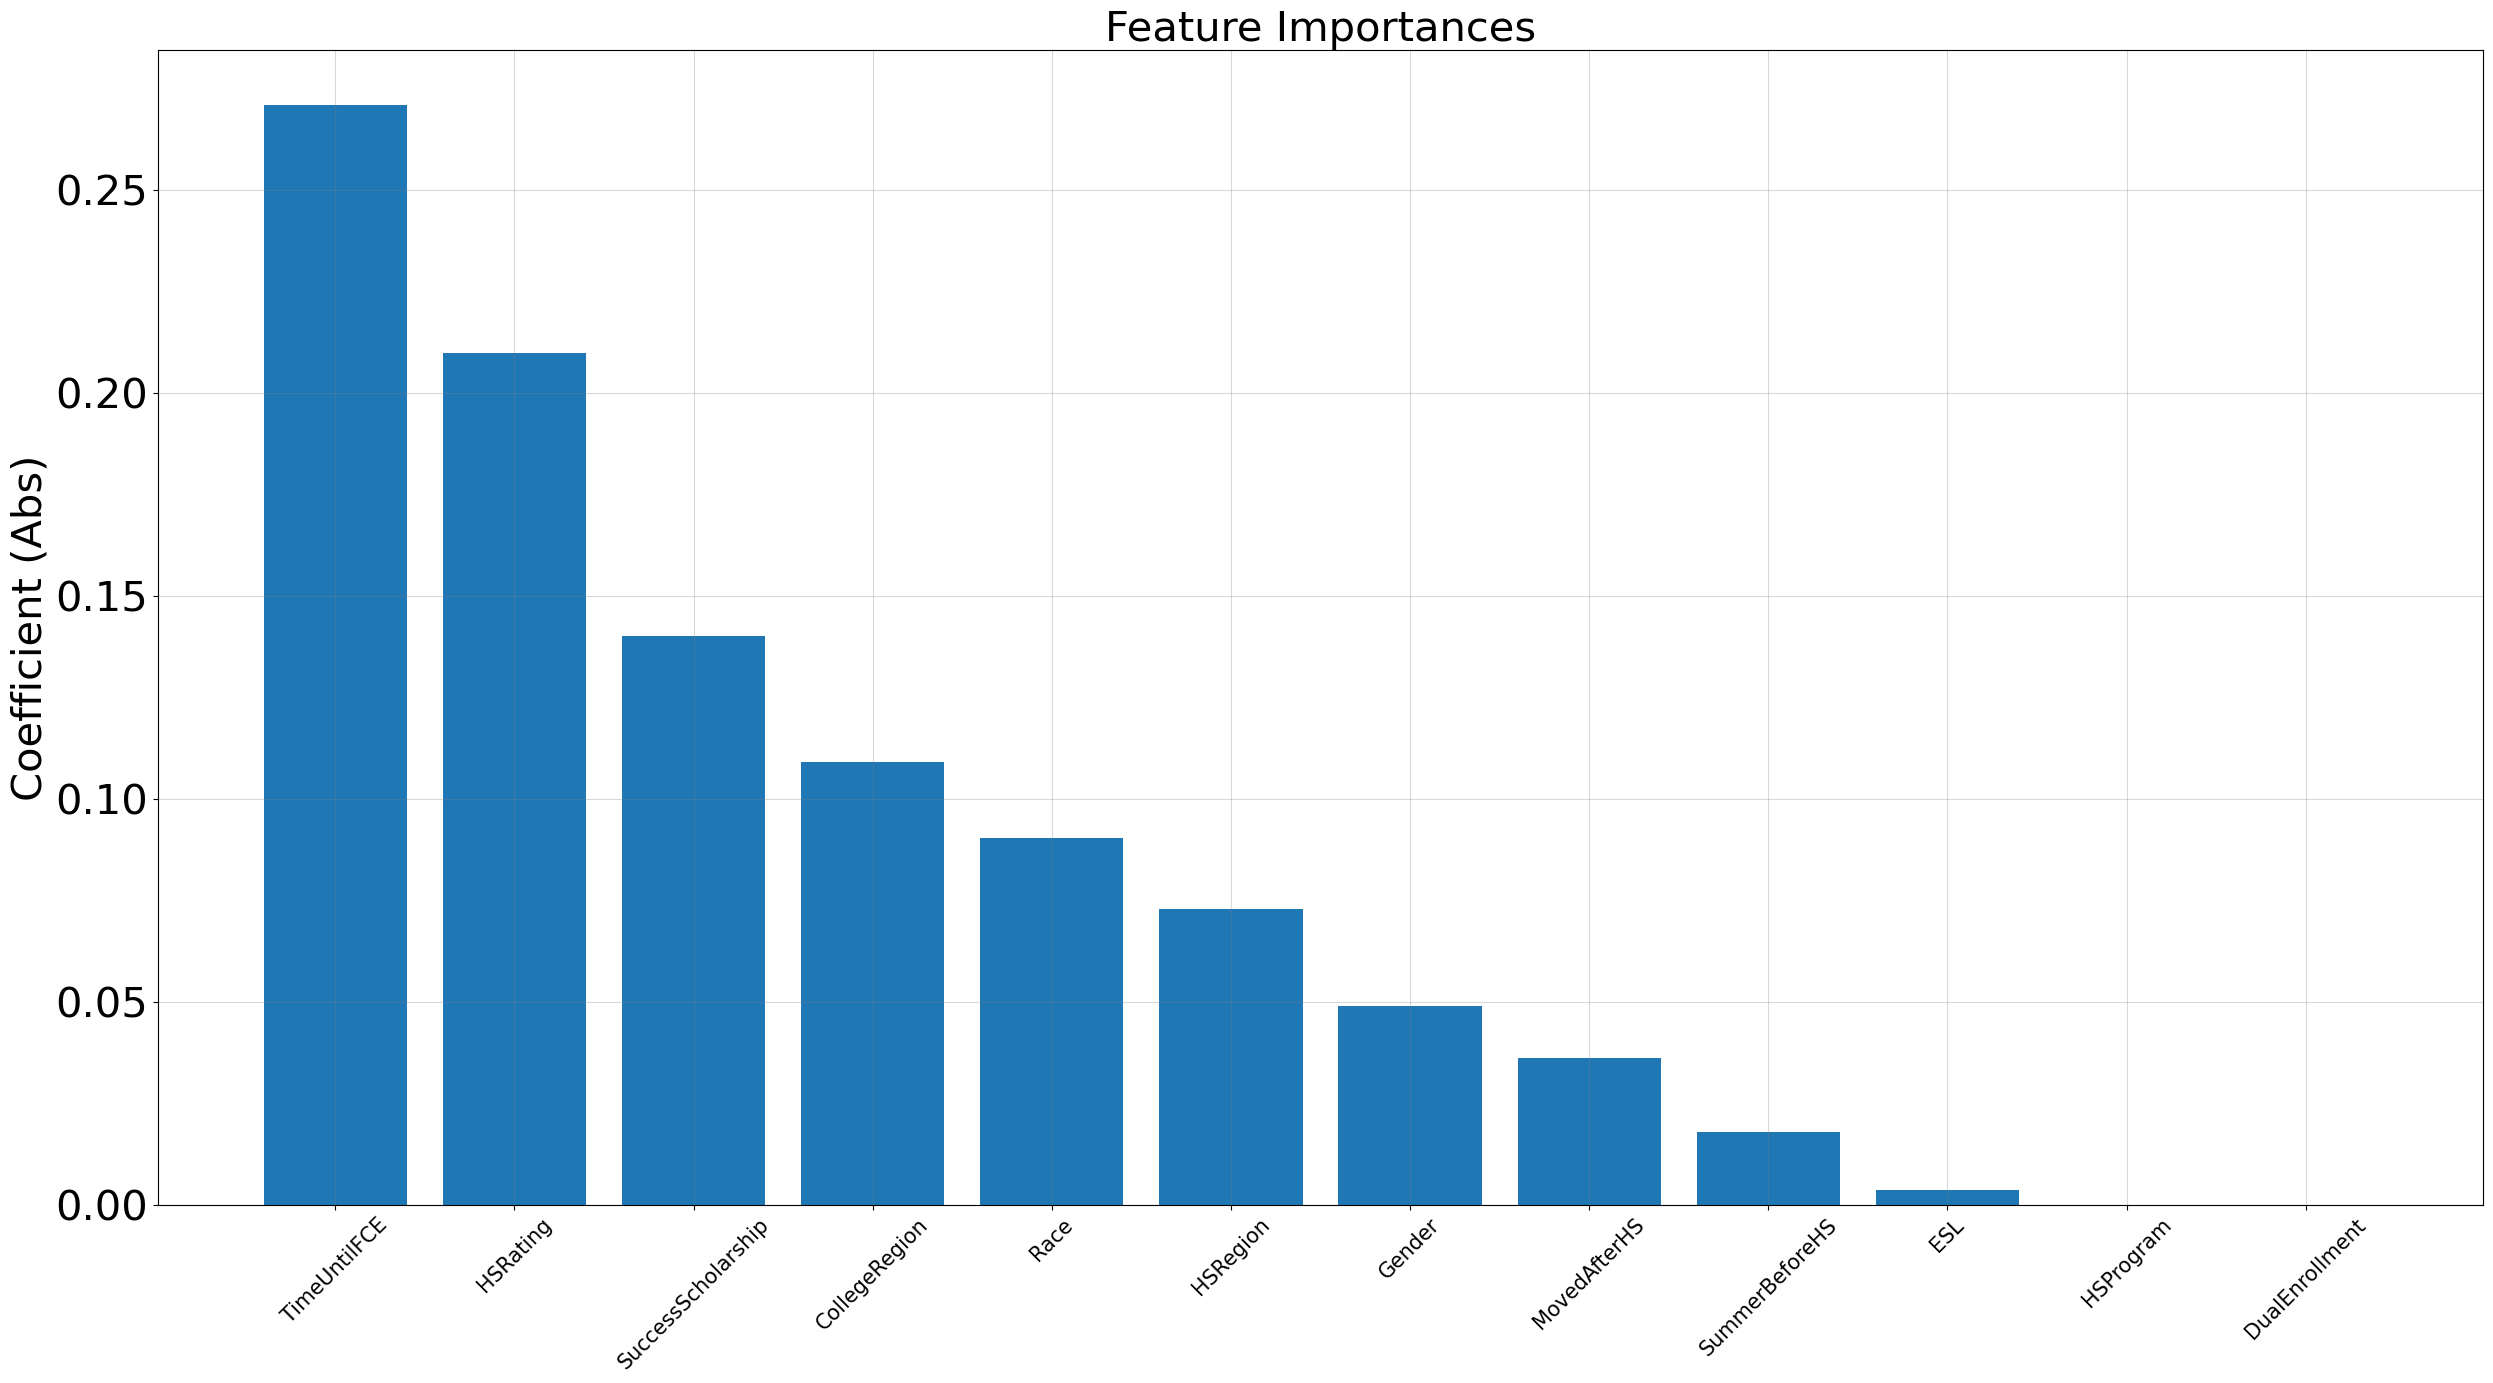

In [16]:
importances = pd.DataFrame(data={
    'Feature': X_train.columns,
    'Importance': randomForestBestPipe.named_steps['randomForest'].feature_importances_,
    'Importance (Abs)':abs(randomForestBestPipe.named_steps['randomForest'].feature_importances_)
})

importances = importances.sort_values(by='Importance (Abs)', ascending=False)

fig, ax = plt.subplots(1, figsize = (30, 15))
ax.bar(x=importances['Feature'], height=importances['Importance (Abs)'])
ax.set_title('Feature Importances', size = 30)
ax.set_ylabel('Coefficient (Abs)', fontsize = 30)
ax.tick_params(axis = 'x',labelrotation=45, labelsize=15)
ax.tick_params(axis = 'y',  labelsize=30)
ax.yaxis.grid(color='gray', alpha=0.3)
ax.xaxis.grid(color='gray', alpha=0.3)

plt.show();

The likelihood of a student persisting to their second year of college is most strongly influenced by the following top five factors:

- Participation in a summer program offered by their college after high school graduation
- Attended a high school with a high rating
- Enrolled in a Success program with a scholarship
- Geographic location of the college attended
- Race

In [17]:
#Get a table of the observed drop-out rate for each decile calculated based on the predicted dropout rate
y_data = [y_train, y_test]
y_predict_proba = [y_train_predicted_proba, y_test_predicted_proba]

for i in range(0,2):
    y_Joined = pd.DataFrame(y_data[i]).reset_index(drop=True).join(pd.DataFrame(y_predict_proba[i]).reset_index(drop=True)).rename(columns = {1:'dropOutProb'})
    label = list(range(1,11,1))
    y_Joined['Decile'] = pd.qcut(y_Joined['dropOutProb'],10, label)

    #Count of drop-out students in each bin
    dfSubscribed = pd.DataFrame(y_Joined.groupby('Decile')['persistIndicator'].sum()).reset_index().rename(columns = {"persistIndicator":"Dropout"})

    #Count of records in each bin
    dfTotal = pd.DataFrame(y_Joined.groupby('Decile')['persistIndicator'].count()).reset_index().rename(columns = {"persistIndicator":"Total"})

    #Generate a dataset with the drop-out rate for each decile
    dfStats = pd.merge(dfSubscribed, dfTotal, on = 'Decile')

    dfStats['Observed Dropout Rate'] = dfStats['Dropout'] / dfStats['Total']
    if i == 0:
        dfStatsTrain = dfStats.copy()
    else:
        dfStatsTest = dfStats.copy()
        
dfStatsTrain

dfStatsTrain.to_csv("data/DecileStats_RandomForest_Train.csv")
dfStatsTest.to_csv("data/DecileStats_RandomForest_Test.csv")

,Decile,Dropout,Total,Observed Dropout Rate
0,1,11,106,0.103774
1,2,11,103,0.106796
2,3,20,104,0.192308
3,4,28,107,0.261682
4,5,29,102,0.284314
5,6,34,104,0.326923
6,7,50,107,0.467290
7,8,40,102,0.392157
8,9,51,104,0.490385
9,10,70,105,0.666667


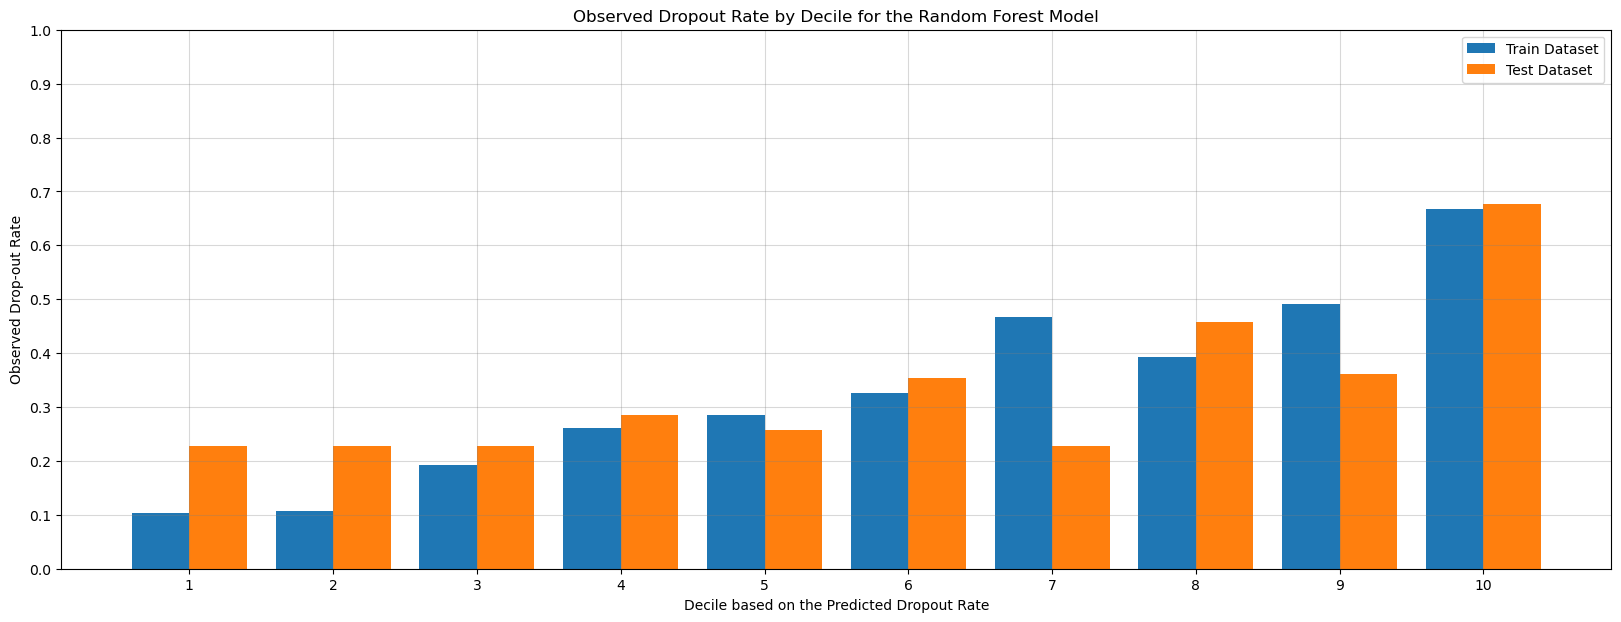

In [18]:
#Generate a chart to observe the rank ordering capability of the model
fig,ax = plt.subplots(figsize = (20, 7))

X_label = np.arange(1,11,1)
plt.bar(X_label - 0.2,  dfStatsTrain['Observed Dropout Rate'],width = 0.4,label = 'Train Dataset')
plt.bar(X_label + 0.2,  dfStatsTest['Observed Dropout Rate'], width = 0.4,label = 'Test Dataset' )
plt.xlabel("Decile based on the Predicted Dropout Rate")
plt.ylabel("Observed Drop-out Rate")
plt.title("Observed Dropout Rate by Decile for the Random Forest Model")
plt.xticks(X_label)
plt.yticks(np.linspace(0,1,11))
plt.legend()
ax.yaxis.grid(color='gray', alpha=0.3)
ax.xaxis.grid(color='gray', alpha=0.3)

plt.show();

- The presented chart demonstrates the model's capacity to rank students based on their likelihood of dropping out of college.
- The chart makes it clear that students in the top deciles are significantly more likely to drop out than those in the lower deciles.
- The observed fluctuations in dropout rates should be addressed.

### B. Build a gradient boosting model

In [19]:
#Build a pipeline for a gradient boosting model
gradientBoostingPipe = Pipeline([('transformer',transformer),
                     ('gradientBoosting',GradientBoostingClassifier(random_state = 42))])

In [20]:
#Tune the gradient boost - define parameters for the search algorithm
n_estimators = np.linspace(100, 1000, int((1000-100)/200) + 1, dtype=int) # number of boosting stages
max_features = ['auto','log2', None] # number of features to consider at every split
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200] # Maximum depth of the individual regression estimators
min_samples_leaf = [10, 20, 50] # minimum number of samples required at each leaf
criterion = ['friedman_mse', 'squared_error']

random_grid = {'gradientBoosting__n_estimators':n_estimators,
               'gradientBoosting__max_features':max_features,
               'gradientBoosting__max_depth':max_depth,
               'gradientBoosting__min_samples_leaf':min_samples_leaf,
               'gradientBoosting__criterion':criterion}

random_grid

{'gradientBoosting__n_estimators': array([ 100,  325,  550,  775, 1000]),
 'gradientBoosting__max_features': ['auto', 'log2', None],
 'gradientBoosting__max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
 'gradientBoosting__min_samples_leaf': [10, 20, 50],
 'gradientBoosting__criterion': ['friedman_mse', 'squared_error']}

In [21]:
#Grid search for the gradient boosting classifier
roc_grid_gradientBoosting = RandomizedSearchCV(gradientBoostingPipe,
                        param_distributions = random_grid, 
                        random_state = 42, n_jobs = 4).fit(X_train, y_train)
roc_grid_gradientBoosting.best_params_

{'gradientBoosting__n_estimators': 100,
 'gradientBoosting__min_samples_leaf': 50,
 'gradientBoosting__max_features': None,
 'gradientBoosting__max_depth': 75,
 'gradientBoosting__criterion': 'squared_error'}

In [22]:
#Build a gradient boosting classifierwith the best parameters
gradientBoostingBestPipe = Pipeline([('transformer',transformer),
                     ('gradientBoosting',GradientBoostingClassifier(
                     n_estimators = roc_grid_gradientBoosting.best_params_.get('gradientBoosting__n_estimators'), 
                     min_samples_leaf = roc_grid_gradientBoosting.best_params_.get('gradientBoosting__min_samples_leaf'),
                     max_features = roc_grid_gradientBoosting.best_params_.get('gradientBoosting__max_features'),
                     max_depth = roc_grid_gradientBoosting.best_params_.get('gradientBoosting__max_depth'),
                     criterion = roc_grid_gradientBoosting.best_params_.get('gradientBoosting__criterion'),
                     random_state = 42))]).fit(X_train,y_train)

In [23]:
#Calculate predicted values, both the classifier and the probability
y_train_predicted = gradientBoostingBestPipe.predict(X_train)
y_test_predicted = gradientBoostingBestPipe.predict(X_test)

y_train_predicted_proba = gradientBoostingBestPipe.predict_proba(X_train)
y_test_predicted_proba = gradientBoostingBestPipe.predict_proba(X_test)

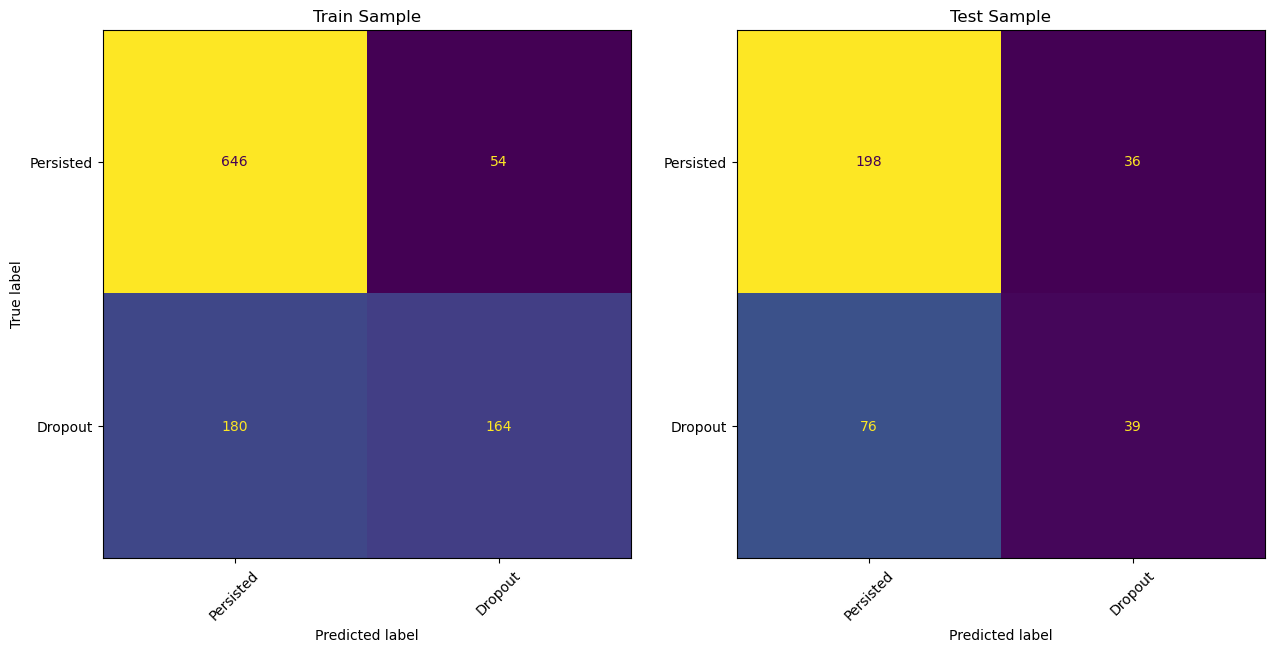

In [24]:
#Display the confusion matrix
dataList = [y_train,y_test]
predictedList = [y_train_predicted, y_test_predicted]
dataLabels = ['Train Sample','Test Sample']

fig, ax = plt.subplots(1,2, figsize = (15,15))
#plt.rcParams.update({'font.size': 20})

for i,j in enumerate(predictedList):
    confusionMatrix= confusion_matrix(dataList[i],j)
    disp = ConfusionMatrixDisplay(confusionMatrix, display_labels = ['Persisted','Dropout'])
    disp.plot(ax=ax[i], xticks_rotation=45)
    disp.ax_.set_title(dataLabels[i])
    disp.im_.colorbar.remove()
    if i!=0:
        disp.ax_.set_ylabel('')

plt.show();

- In the train sample, there are 180 instances of false negatives (classified as persistent even though a dropout), or missed opportunities where the necessary interventions were not taken to retain students in college. The test sample reports 76 false negatives.
- The train sample also shows a high occurrence of false positives, or instances where the investment was misallocated, with 54 cases. This statistic decreases to 36 in the test sample.
- It is imperative to strive for minimizing both false negatives and false positives in order to maximize success in retaining students and effectively utilizing resources.

In [25]:
#Function to generate summary stats, accuracy, precision, recall, f1-score and AUC
def generateModelSummaryStats(y_train, y_train_predicted, y_test, y_test_predicted,y_train_predicted_proba,y_test_predicted_proba):
    trainStats = []
    testStats = []
    
    trainStats.append(np.round(accuracy_score(y_train,y_train_predicted),3))
    if (np.sum(y_train_predicted) == 0):
        trainStats.append("N/A")
    else:
        trainStats.append(np.round(precision_score(y_train,y_train_predicted),3))
    trainStats.append(np.round(recall_score(y_train,y_train_predicted),3))
    trainStats.append(np.round(f1_score(y_train,y_train_predicted),3))
    trainStats.append(np.round(roc_auc_score(y_train, y_train_predicted_proba[:,1]),3))
    
    testStats.append(np.round(accuracy_score(y_test,y_test_predicted),3))
    if (np.sum(y_test_predicted) == 0):
        testStats.append("N/A")
    else:
        testStats.append(np.round(precision_score(y_test,y_test_predicted),3))
    testStats.append(np.round(recall_score(y_test,y_test_predicted),3))
    testStats.append(np.round(f1_score(y_test,y_test_predicted),3))
    testStats.append(np.round(roc_auc_score(y_test, y_test_predicted_proba[:,1]),3))
    
    #Summarize results
    listOfStats = ['Accuracy','Precision','Recall','F1 Score','AUC']
    dfStats = pd.DataFrame(zip(listOfStats, trainStats, testStats), columns = ['Metric','Train Sample','Test Sample'])
    return(dfStats)

In [26]:
#Generate summary statistics
generateModelSummaryStats(y_train, y_train_predicted, y_test, y_test_predicted,y_train_predicted_proba,y_test_predicted_proba)

,Metric,Train Sample,Test Sample
0,Accuracy,0.776,0.679
1,Precision,0.752,0.520
2,Recall,0.477,0.339
3,F1 Score,0.584,0.411
4,AUC,0.837,0.653


In [27]:
#Generate the data to create the ROC data
y_data = [y_train, y_test]
y_predict_proba = [y_train_predicted_proba[:,1], y_test_predicted_proba[:,1]]

for i in range(0,2):
    fpr, tpr, thresholds = roc_curve(y_data[i], y_predict_proba[i])
    if (i == 0):
        fpr_train = fpr
        tpr_train = tpr
        thresholds_train = thresholds
    else:
        fpr_test = fpr
        tpr_test = tpr
        thresholds_test = thresholds

fpr_tpr_train = pd.DataFrame({'fpr':fpr_train,'tpr':tpr_train})
fpr_tpr_test = pd.DataFrame({'fpr':fpr_test,'tpr':tpr_test})
fpr_tpr_train.to_csv("data/fpr_tpr_GradientBoosting_Train.csv")
fpr_tpr_test.to_csv("data/fpr_tpr_GradientBoosting_Test.csv")

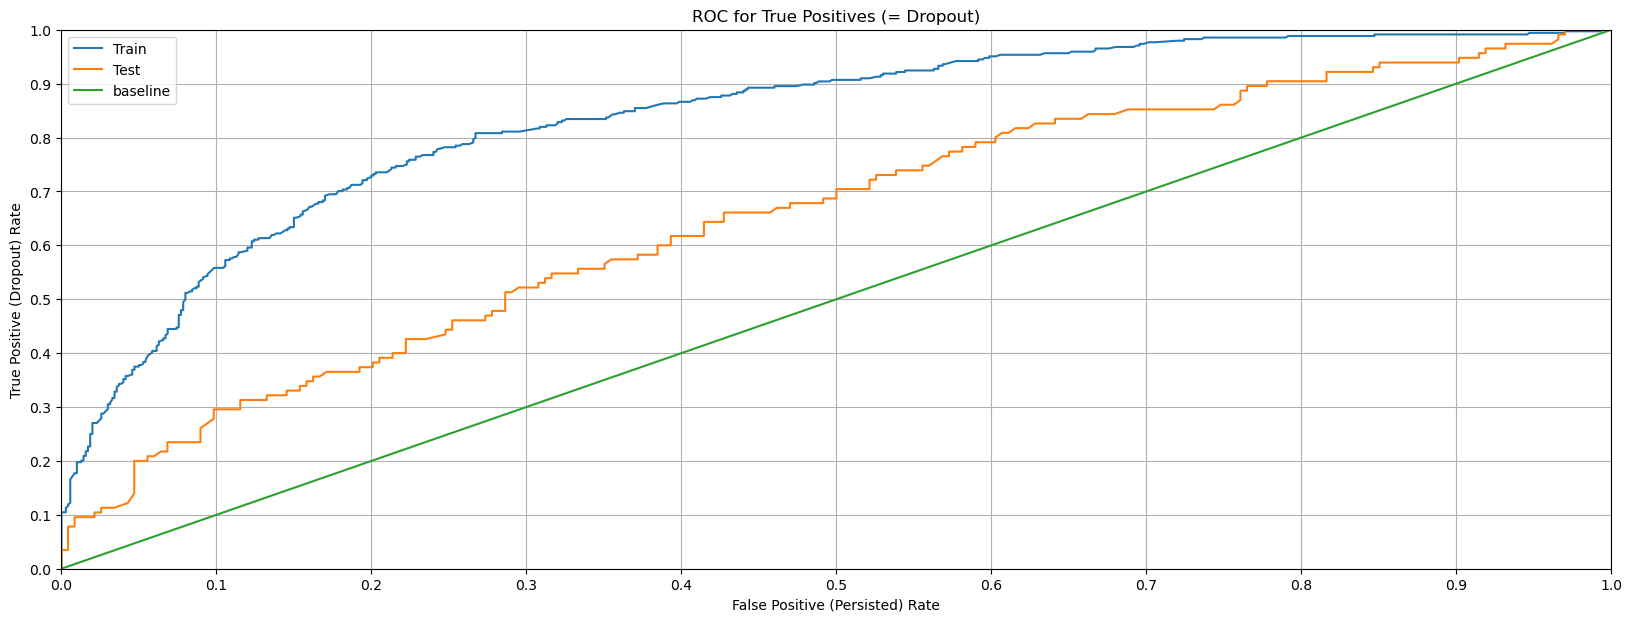

In [28]:
#Generate a chart to observe the rank ordering capability of the model
fig,ax = plt.subplots(figsize = (20, 7))

plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')

plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.xlabel('False Positive (Persisted) Rate')
plt.ylabel('True Positive (Dropout) Rate')
plt.title('ROC for True Positives (= Dropout)')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.legend();

- The chart above provides insight into our model's capacity to identify students who have dropped out.
- According to the training sample, the model can predict a considerable 70% of students who dropped out within the bottom 20% of those who persisted.
- However, this figure drops to below 40% on the test sample, suggesting that the model is overfitting to the training data.

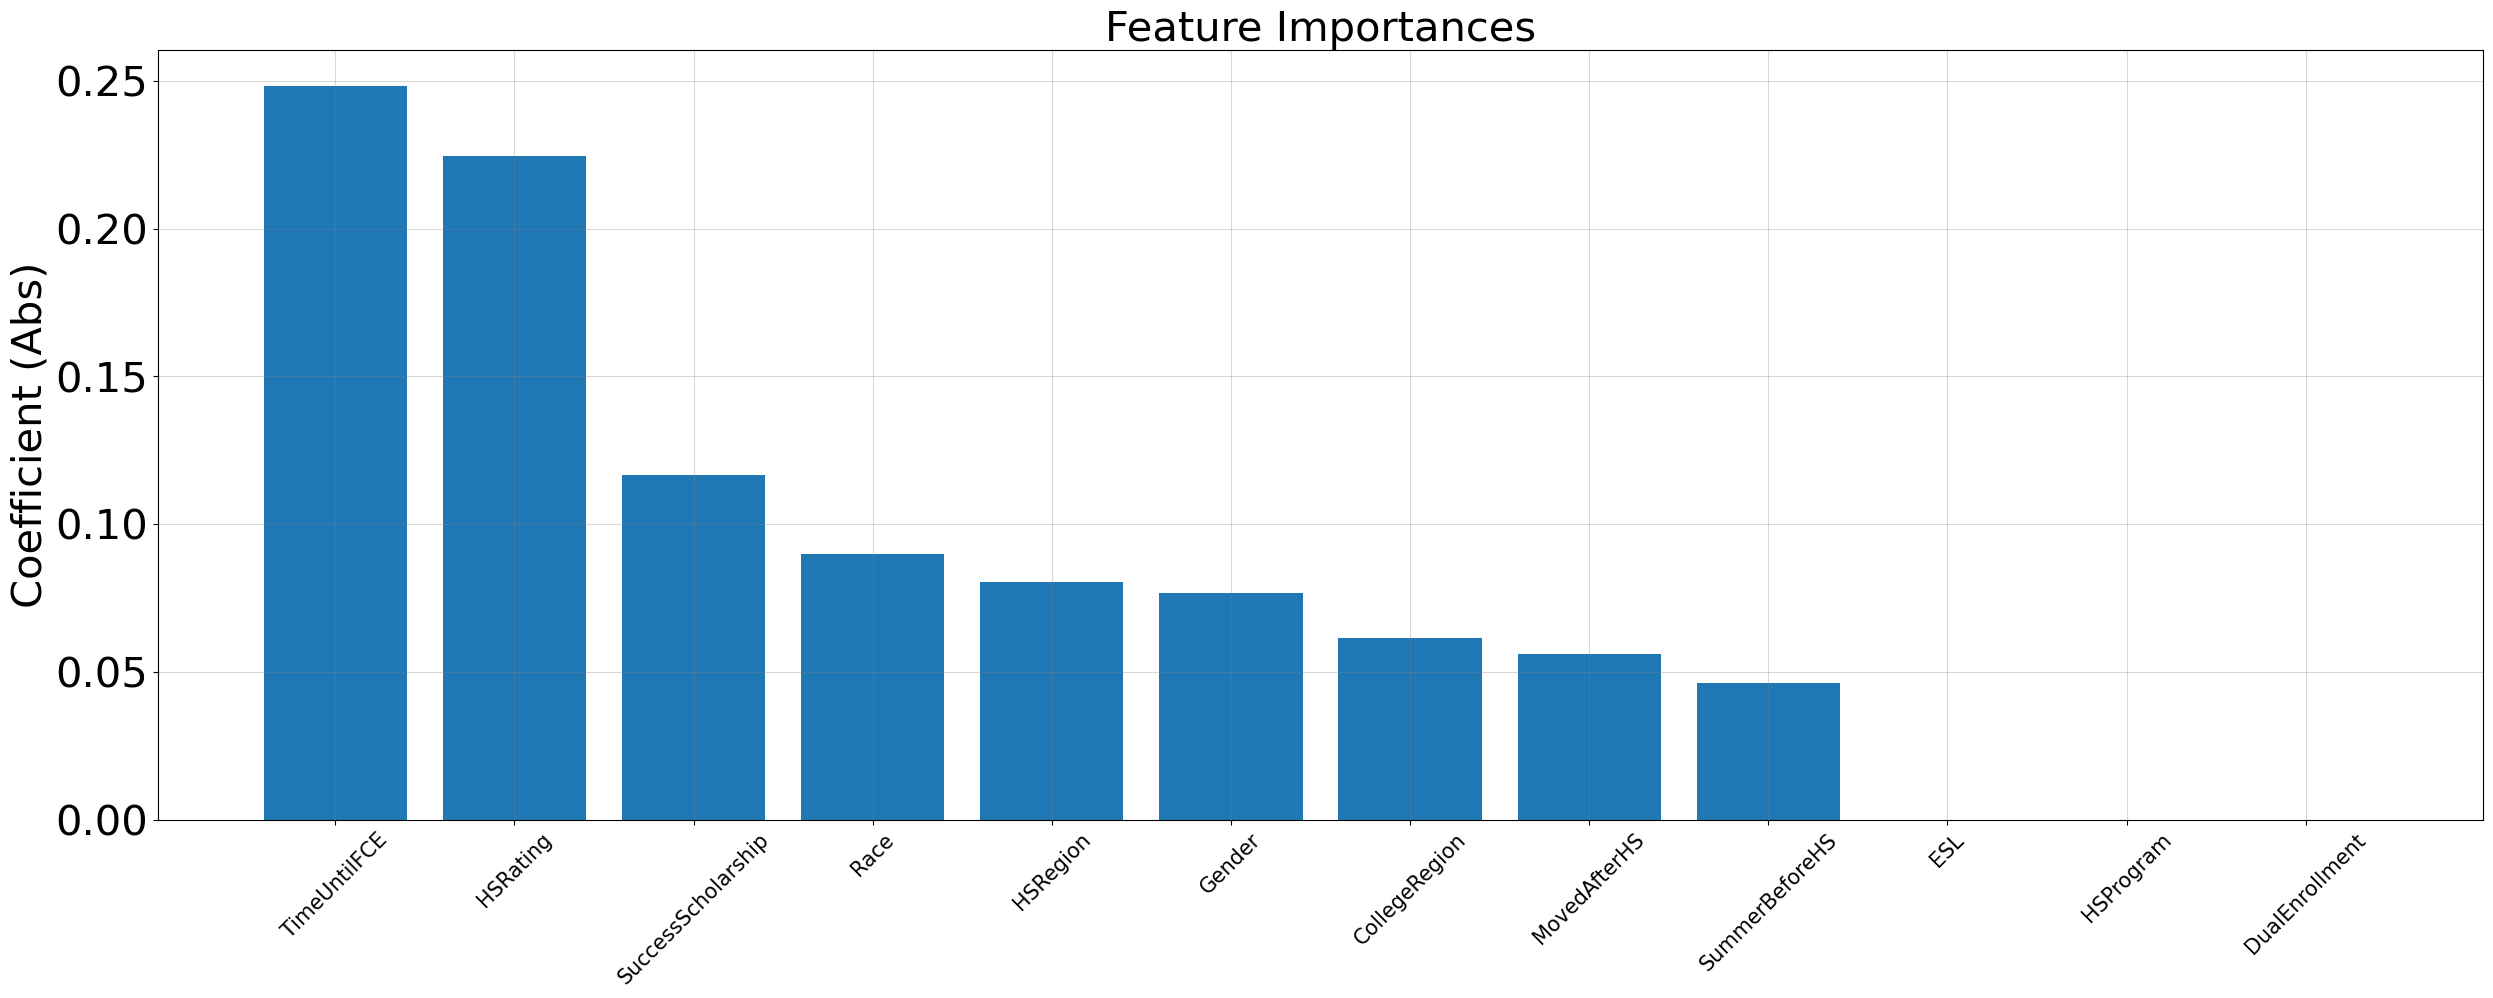

In [29]:
importances = pd.DataFrame(data={
    'Feature': X_train.columns,
    'Importance': gradientBoostingBestPipe.named_steps['gradientBoosting'].feature_importances_,
    'Importance (Abs)':abs(gradientBoostingBestPipe.named_steps['gradientBoosting'].feature_importances_)
})

importances = importances.sort_values(by='Importance (Abs)', ascending=False)

fig, ax = plt.subplots(1, figsize = (30, 10))
ax.bar(x=importances['Feature'], height=importances['Importance (Abs)'])
ax.set_title('Feature Importances', size = 30)
ax.set_ylabel('Coefficient (Abs)', fontsize = 30)
ax.tick_params(axis = 'x',labelrotation=45, labelsize=15)
ax.tick_params(axis = 'y',  labelsize=30)
ax.yaxis.grid(color='gray', alpha=0.3)
ax.xaxis.grid(color='gray', alpha=0.3)

plt.show();

The likelihood of a student persisting to their second year of college is most strongly influenced by the following top five factors:

- Participation in a summer program offered by their college after high school graduation
- Attended a high school with a high rating
- Enrolled in a Success program with a scholarship
- Race
- Geographic location of the college attended

In [30]:
#Get a table of the observed drop-out rate for each decile calculated based on the predicted drop-out rate
y_data = [y_train, y_test]
y_predict_proba = [y_train_predicted_proba, y_test_predicted_proba]

for i in range(0,2):
    y_Joined = pd.DataFrame(y_data[i]).reset_index(drop=True).join(pd.DataFrame(y_predict_proba[i]).reset_index(drop=True)).rename(columns = {1:'dropOutProb'})
    label = list(range(1,11,1))
    y_Joined['Decile'] = pd.qcut(y_Joined['dropOutProb'],10, label )

    #Count of drop-out students in each bin
    dfSubscribed = pd.DataFrame(y_Joined.groupby('Decile')['persistIndicator'].sum()).reset_index().rename(columns = {"persistIndicator":"Dropout"})

    #Count of records in each bin
    dfTotal = pd.DataFrame(y_Joined.groupby('Decile')['persistIndicator'].count()).reset_index().rename(columns = {"persistIndicator":"Total"})

    #Generate a dataset with the drop-out rate for each decile
    dfStats = pd.merge(dfSubscribed, dfTotal, on = 'Decile')

    dfStats['Observed Dropout Rate'] = dfStats['Dropout'] / dfStats['Total']
    if i == 0:
        dfStatsTrain = dfStats.copy()
    else:
        dfStatsTest = dfStats.copy()
        
dfStatsTrain
dfStatsTest

dfStatsTrain.to_csv("data/DecileStats_GradientBoosting_Train.csv")
dfStatsTest.to_csv("data/DecileStats_GradientBoosting_Test.csv")

,Decile,Dropout,Total,Observed Dropout Rate
0,1,3,108,0.027778
1,2,5,106,0.047170
2,3,12,100,0.120000
3,4,17,104,0.163462
4,5,20,104,0.192308
5,6,26,104,0.250000
6,7,47,105,0.447619
7,8,58,104,0.557692
8,9,65,104,0.625000
9,10,91,105,0.866667


,Decile,Dropout,Total,Observed Dropout Rate
0,1,7,35,0.200000
1,2,7,35,0.200000
2,3,6,35,0.171429
3,4,11,35,0.314286
4,5,10,35,0.285714
5,6,11,35,0.314286
6,7,14,35,0.400000
7,8,12,36,0.333333
8,9,14,33,0.424242
9,10,23,35,0.657143


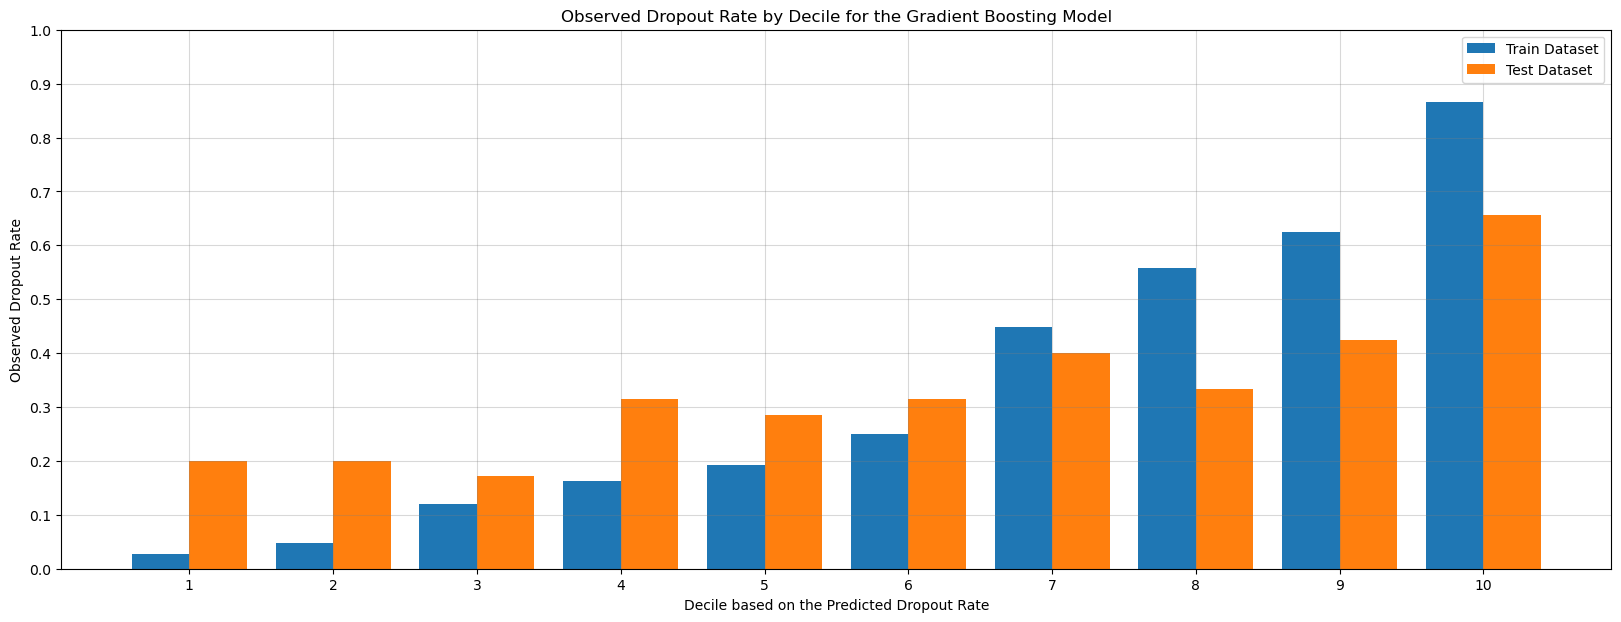

In [31]:
#Generate a chart to observe the rank ordering capability of the model
fig,ax = plt.subplots(figsize = (20, 7))
width = 0.2

X_label = np.arange(1,11,1)
plt.bar(X_label - width,  dfStatsTrain['Observed Dropout Rate'],width = 0.4,label = 'Train Dataset')
plt.bar(X_label + width,  dfStatsTest['Observed Dropout Rate'], width = 0.4,label = 'Test Dataset' )
plt.xlabel("Decile based on the Predicted Dropout Rate")
plt.ylabel("Observed Dropout Rate")
plt.title("Observed Dropout Rate by Decile for the Gradient Boosting Model")
plt.xticks(X_label)
plt.yticks(np.linspace(0,1,11))
plt.legend()
ax.yaxis.grid(color='gray', alpha=0.3)
ax.xaxis.grid(color='gray', alpha=0.3)

plt.show();

- The chart presented above provides insights into the model's ability to rank students by their probability of dropping out of college.
- The chart indicates that students in the top deciles are considerably more likely to drop out compared to those in the lower deciles.
- In the test sample, the dropout rate for the highest scoring decile is over three times greater than that for the lowest scoring decile (65% versus 20%). 
- Dropout rates show no fluctuations in the training sample, while the fluctuations are minimal for the test sample.